<div id="titlepage">
    <h1 style="line-height: 1.5em; margin-bottom: 80px">
        Feature-Selection am Beispiel<br/>
        des Datensatzes &raquo;20 Newsgroups&laquo;
    </h1>
    <table style="font-size: 20px; margin: 0; text-align: left">
        <tr style="background: none">
            <th style="border-style: none; padding-left: 2px">Vorlesung</th>
            <td style="border-style: none">Advanced Data Science Pipelines</td>
        </tr>
        <tr style="background: none">
            <th style="border-style: none; padding-left: 2px">Dozent</th>
            <td style="border-style: none">Christoph Gietl</td>
        </tr>
        <tr style="background: none">
            <th style="border-style: none; padding-left: 2px">Datum</th>
            <td style="border-style: none">14. Juni 2021</td>
        </tr>
        <tr style="background: none">
            <th style="border-style: none; padding-left: 2px">Folien</th>
            <td style="border-style: none"><a href="https://christophgietl.github.io/feature-selection">christophgietl.github.io/feature-selection</a></td>
        </tr>
        <tr style="background: none">
            <th style="border-style: none; padding-left: 2px">Code</th>
            <td style="border-style: none"><a href="https://github.com/christophgietl/feature-selection">github.com/christophgietl/feature-selection</a></td>
        </tr>
    </table>
</div>

In [1]:
import matplotlib.pyplot
import numpy
import random
import sklearn.datasets
import sklearn.feature_extraction.text
import sklearn.feature_selection
import sklearn.linear_model
import sklearn.metrics
import sklearn.model_selection
import sklearn.naive_bayes
import sklearn.pipeline
import sklearn.svm

## Über diese Vorlesung

- Zielgruppe: 5. bis 7. Semester im Studiengang _Data Science & Scientific Computing_
- Fachgruppe: WPF Data-Science
- Vorkenntnisse
    - grundlegende Kenntnisse in Python und scikit-learn
    - Maschinelles Lernen (2. Semester)
    - Datenaufbereitung & Visualisierung (2. Semester)
- Lernziele
    - Kennenlernen und Anwendung von
        - fortgeschrittener Methoden des Maschinellen Lernens
        - Best-Practices aus dem Bereich _Reproducible Data-Science_
    - im Beruf
        - einzeln und im Team komplexe, unstrukturierte und unsaubere Datensätze analysieren zu können
        - Code und Artefakte aus jedem Analyseprozessschritt teilen und archivieren
- Inhalt
    - Fortgeschrittene Datenvorverarbeitung
    - Fortgeschrittene Supervised-Learning-Verfahren
        - Modellregularisierung in Regression und Klassifikation
        - Ensemble-Learning
        - Multiclass- und Multilabel-Probleme
        - Modellkalibrierung
    - Modellevaluation
        - Auswahl geeigneter Metriken
        - Visualisierung von Metriken und Lernfortschritt
    - Strategien für den Umgang mit großen Datenmengen
        - Datenhaltung außerhalb des Arbeitsspeichers
        - Online-Learning
        - Feature-Selection
    - Persistierung und Deployment von Modellen

### Bisher bei Advanced Data Science Pipelines &hellip;

- Datenvorverarbeitung
    - Feature-Extraktion (strukturierte und unstrukturierte Daten)
    - Imputation fehlender Werte
- fortgeschrittene Supervised-Learning-Methoden
    - Modellregularisierung (zur Vermeidung von Overfitting, L1 und L2)
    - Ensemble-Learning
    - Modellkalibrierung
    - Umgang mit Multi-Class- und Multi-Label-Problemen
- Modellevaluation
    - Auswahl geeigneter Metriken
    - Visualisierung von Metriken und Lernfortschritt

### Zwischenfragen erwünscht

- schwierig wahrzunehmen
    - Chat
    - virtuelles Handheben
    - physisches Handheben
- stattdessen bitte einfach
    - entstummen
    - mich unterbrechen
    - Frage stellen

<h2>Datensatz &raquo;20 Newsgroups&laquo; und<br/>Ziel der Modellierung</h2>

### Hintergrund des Datensatzes: Usenet

- historischer Internet-Dienst (neben World-Wide-Web, E-Mail und anderen Diensten)
- unterteilt in zahlreiche Diskussionsforen (sogenannte Newsgroups)
- Nachrichtenformat ähnlich zu E-Mail
    - Kopfzeilen
    - Signaturen
    - Zitate

### Datenquelle und Datenformat

In [2]:
ng20 = sklearn.datasets.fetch_20newsgroups(
    # Der Datensatz wurde bereits in Subsets "train" und "test" unterteilt.
    # Lade den gesamten Datensatz:
    subset="all",
    
    # Wir unterteilen den Datensatz später selbst.
    # Mische den Datensatz gut durch:
    random_state=42,
    shuffle=True,
    
    # Entferne Kopfzeilen, Signaturen und Zitate,
    # um die Zuordnung von Nachrichten zu Personen zu erschweren:
    remove=["headers", "footers", "quotes"]
)

In [3]:
type(ng20.data), type(ng20.target), type(ng20.target_names)

(list, numpy.ndarray, list)

In [4]:
len(ng20.data), len(ng20.target), len(ng20.target_names)

(18846, 18846, 20)

#### Code-Beispiele

- Wie immer gehe ich schnell über den Code hinweg.
- Nicht jede einzelne Zeile muss sofort verstanden werden.
- Wichtige Code-Stellen werden mit dem Mauszeiger hervorgehoben.

#### Input-Daten (erklärende Variablen)

In [5]:
types = set(type(item) for item in ng20.data)
types

{str}

In [6]:
lengths = [len(item) for item in ng20.data]
min(lengths), max(lengths)

(0, 158791)

In [7]:
numpy.mean(lengths).round(1), numpy.std(lengths).round(1)

(1169.7, 3858.6)

#### Output-Daten (Zielvariable)

In [8]:
numpy.unique(ng20.target, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 array([799, 973, 985, 982, 963, 988, 975, 990, 996, 994, 999, 991, 984,
        990, 987, 997, 910, 940, 775, 628]))

In [9]:
print(ng20.target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


#### Beispielnachricht aus dem Datensatz (Input- und Output-Daten)

In [10]:
print(ng20.data[4_328][:434])


Not when your talking about cryptography.


Think again.  You won't see me using apple's new signature from the
finder feature.


This analogy fails in its assumption that the government gives two
squirts about credibility.


In addition, Apple's proclaimed purpose in releasing the Macintosh wasn't
survellience.

Quite the opposite:
"On January 24, Apple will introduce.... Macintosh, and you'll see why
1984 won't be, like '1984'"


In [11]:
ng20.target[4_328], ng20.target_names[ng20.target[4_328]]

(11, 'sci.crypt')

### Ziel der Modellierung: Thematischer Textklassifikator

- nimmt Texte entgegen
- ordnet sie jeweils einem der 20 Themen zu (entsprechend den 20 Newsgroups)

## Datenmodellierung unter Verwendung bisheriger Kenntnisse

### Preprocessing der Daten

In [12]:
# Aufteilung des Datensatzes in Trainings- und Testdaten:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    ng20.data,
    ng20.target,
    random_state=42,
    stratify=ng20.target, # gleiche relative Klassenhfgktn. in Trainings- und Testdaten
    test_size=2_000       # nötig für aussagekräftige Metriken bei 20 Klassen
)

In [13]:
# Balance der Trainingsdaten:
numpy.unique(y_train, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 array([714, 870, 880, 878, 861, 883, 872, 885, 890, 889, 893, 886, 880,
        885, 882, 891, 813, 840, 693, 561]))

In [14]:
# Balance der Testdaten:
numpy.unique(y_test, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 array([ 85, 103, 105, 104, 102, 105, 103, 105, 106, 105, 106, 105, 104,
        105, 105, 106,  97, 100,  82,  67]))

### Feature-Extraction mittels TF-IDF-Vectorizer

In [15]:
# Der TF-IDF-Vectorizer transformiert Listen von Strings (=Texten) in Matrizen:
xtrct = sklearn.feature_extraction.text.TfidfVectorizer(
    stop_words="english" # Wörter wie "the" und "is" werden nicht berücksichtigt.
)

In [16]:
# Der Naive-Bayes-Klassifikator hat sich im Bereich Textklassifikation etabliert: 
clssf_nb = sklearn.naive_bayes.ComplementNB()

In [17]:
# Verbinde Feature-Extractor und Klassifikator zu einer Pipeline:
ppln = sklearn.pipeline.Pipeline([
    ("xtrct", xtrct),
    ("clssf", clssf_nb)
])

### Modellanpassung

In [18]:
# Wiederverwendbare Logik zur Anpassung von Pipelines an den Datensatz (X_train, y_train):
def cross_validate_and_fit(estimator, param_grid):
    gscv = sklearn.model_selection.GridSearchCV(
        estimator=estimator,
        n_jobs=3,
        param_grid=param_grid,
        return_train_score=True,
        # Die gewichtete Area Under the Curve ist eine stabile Metrik
        # zum Tuning von Multiclass-Klassifikatoren:
        scoring="roc_auc_ovr_weighted",
        verbose=9
    )
    gscv.fit(X_train, y_train)
    print()
    
    print(f"Parameters:       {gscv.cv_results_['params']}")
    print(f"Mean train score: {gscv.cv_results_['mean_train_score'].round(3)}")
    print(f"Mean test score:  {gscv.cv_results_['mean_test_score'].round(3)}")
    
    return gscv


tuned_ppln = cross_validate_and_fit(
    estimator=ppln,
    param_grid={"clssf__alpha": [0.01, 0.03, 0.1, 0.3, 1.0]} # Regularisier. d. NB-Klass.
)

Fitting 5 folds for each of 5 candidates, totalling 25 fits

Parameters:       [{'clssf__alpha': 0.01}, {'clssf__alpha': 0.03}, {'clssf__alpha': 0.1}, {'clssf__alpha': 0.3}, {'clssf__alpha': 1.0}]
Mean train score: [0.998 0.997 0.997 0.995 0.993]
Mean test score:  [0.973 0.975 0.977 0.976 0.974]


#### Bemerkung: Naive-Bayes-Klassifikator

- wurde im Rahmen der Vorlesung bis jetzt nicht behandelt
- bewährtes Modell im Rahmen der Textklassifikation

### Evaluation der Pipeline

In [19]:
# Wiederverwendbare Logik zur Ausgabe einer sortierten Stichprobe aus einer Liste:
def print_sorted_samples(lst):
    rng = numpy.random.default_rng(seed=42)
    samples = rng.choice(lst, replace=False, size=100)
    samples.sort()
    print(samples)

#### Features (vom Extractor erzeugt)

In [20]:
feature_names = tuned_ppln.best_estimator_.named_steps["xtrct"].get_feature_names()
len(feature_names)

127345

In [21]:
print_sorted_samples(feature_names)

['2024' '3388' '3999' '417' '4tq1jv' '5286' '578' '5e8g4' '5pv'
 '83jx0dadf' '87___________________' '93109' '_cheap_' '_rqpp4db' 'a4gc0'
 'ak' 'anafranil' 'ap8h' 'arromdian' 'bench' 'benes' 'booktitle'
 'circumstantial' 'comparitive' 'cyberspace' 'delia' 'despised' 'dxsx'
 'eighth' 'ellison' 'endlessly' 'endprocedure' 'f0j' 'fjpbkbpu' 'frame'
 'glucoma' 'goofy' 'grad' 'gravis' 'gukasian' 'gyv' 'hallandale'
 'hallucinating' 'hippi' 'homelessness' 'howell' 'hyqe' 'institutional'
 'interplanetary' 'janney' 'k2mv5805t' 'kzm' 'l4y4j2' 'leedom' 'lmrcr1o'
 'mtm' 'multipath' 'myopia' 'nb6c' 'noble' 'oi_w_' 'orthogonal'
 'overwhelming' 'owen' 'p90t' 'pendelum' 'petah' 'petcock' 'ppw' 'q6p1i'
 'quiet' 'qwt' 'redneck' 'regent' 'reincarnated' 'restrains' 'ripem'
 'roelle' 'rq9' 'rythm' 'scatter' 'serials' 'sng' 'spaceward' 'sq9wmgk'
 'squalid' 'stg' 'strategic' 't5k1' 't5m19' 'trp' 'tyrant' 'ug3'
 'uniformed' 'vdu' 'victimized' 'walkie' 'xhm' 'xoutput_info'
 'xtungrabpointer']


#### Koeffizienten des Klassifikators

In [22]:
coefficients = tuned_ppln.best_estimator_.named_steps["clssf"].feature_log_prob_
coefficients.shape

(20, 127345)

In [23]:
numpy.prod(coefficients.shape), (coefficients==0).any()

(2546900, False)

### Neues Ziel der Modellierung: _Kompakter_ thematischer Textklassifikator

- nimmt Texte entgegen
- ordnet sie jeweils einem der 20 Themen zu (entsprechend den 20 Newsgroups)
- _**Auditierbarkeit:** Entscheidungsprozess für Stakeholder:innen innerhalb und außerhalb des Unternehmens nachvollziehbar und dokumentiert_

#### Hindernis

Zu viele Features und Koeffizienten
- erschweren Dokumentation und
- verhindern Nachvollziehbarkeit.

## Einführung in die Feature-Selection

### Grundgedanke der Feature-Selection

- Idee
    - Entferne &raquo;unnütze&laquo; Features vor der Anpassung des finalen Modells.
    - Behalte nur die &raquo;nützlichen&laquo; Features.
- Ziel: kompaktes Modell
- Vorteile
    - schnellere Berechnung der Vorhersagen
    - bessere Interpretierbarkeit
- Nachteile
    - in der Regel höhere Trainingszeit
    - in der Regel (geringfügig) schlechtere Vorhersagequalität
- Anwendungsgebiete
    - Datensätze mit vielen Features _(bspw. in der Bioinformatik)_
    - aufwendige Datenerfassung _(bspw. Labortests oder Fragebögen)_
    - Bedarf nach interpretierbaren Modellen<br/>_(bspw. wg. regulator. Anforderungen o. zur Verbesserung des Vertrauens)_
    - Deployment auf Maschinen mit eingeschränkter Rechenleistung<br/>_(bspw. im Internet-of-Things-Umfeld)_

### Feature-Selection-Methoden im Überblick

#### Filter-Methoden

- Algorithmus
    - Berechne für jedes Feature die Interaktion mit der Zielvariablen.
    - Entferne alle Features, deren Interaktionswert unterhalb einer bestimmten Schwelle liegt.
- Schwierigkeit
    - Auswahl des geeigneten Interaktionsmaßes
        - diskrete vs. kontinuierliche Variablen
        - lineare vs. nichtlineare Interaktion
- Vorteile
    - schnelle Berechnung
    - numerische Stabilität
    - gute Skalierbarkeit
- Nachteile
    - keine Berücksichtigung des Modells
    - mögliche Entfernung von Features, die für das Modell wichtig sind
- Empfehlung
    - vorsichtig verwenden
    - nicht zu viele Features entfernen

#### Wrapper-Methoden

- Idee
    - Passe Modell auf einer Teilmenge der Features an.
    - Bewerte die Modellqualität.
    - Verbessere die Teilmenge der Features iterativ.
- Vorteil
    - Features, die nur in Kombination nützlich sind, können beibehalten werden.
- Nachteil
    - teure Berechnung

#### Embedded-Methoden

- Idee: Modell trifft während des Trainings eine Auswahl der Features.
- Beispiele
    - Entscheidungsbäume
    - lineare Modelle mit L1-Regularisierung
- Vorteil
    - schnelle Berechnung
    - Auswahl von Features, die für das Modell nützlich sind
- Nachteil
    - weniger mächtig als Wrapper-Methoden

<h2>Erweiterung der Modell-Pipeline<br/>um Feature-Selection</h2>

### Evaluation verschiedener Feature-Selection-Methoden

#### Filter-Methode mit Chi-Quadrat-Statistik

In [24]:
slct_kbest_chi2 = sklearn.feature_selection.SelectKBest(
    score_func=sklearn.feature_selection.chi2
)
ppln_fltr = sklearn.pipeline.Pipeline([
    ("xtrct", xtrct),
    ("slct", slct_kbest_chi2),
    ("clssf", clssf_nb)
])
tuned_ppln_fltr = cross_validate_and_fit(
    estimator=ppln_fltr,
    param_grid={
        "slct__k": [100, 300, 1_000, 3_000, 10_000, 30_000, "all"],
        "clssf__alpha": [0.1]
    }
)

Fitting 5 folds for each of 7 candidates, totalling 35 fits

Parameters:       [{'clssf__alpha': 0.1, 'slct__k': 100}, {'clssf__alpha': 0.1, 'slct__k': 300}, {'clssf__alpha': 0.1, 'slct__k': 1000}, {'clssf__alpha': 0.1, 'slct__k': 3000}, {'clssf__alpha': 0.1, 'slct__k': 10000}, {'clssf__alpha': 0.1, 'slct__k': 30000}, {'clssf__alpha': 0.1, 'slct__k': 'all'}]
Mean train score: [0.865 0.924 0.96  0.978 0.991 0.996 0.997]
Mean test score:  [0.861 0.918 0.95  0.965 0.973 0.976 0.977]


#### Wrapper-Methoden

- kommen nicht infrage
- rechnerisch zu aufwendig aufgrund der hohen Feature-Zahl

#### Embedded-Methoden

##### Logistische Regression mit L1-Regularisierung

In [25]:
clssf_lr = sklearn.linear_model.LogisticRegression(
    penalty="l1",
    random_state=42,
    solver="liblinear"
)
ppln_embd_lr = sklearn.pipeline.Pipeline([
    ("xtrct", xtrct),
    ("clssf", clssf_lr)
])
tuned_ppln_embd_lr = cross_validate_and_fit(
    estimator = ppln_embd_lr,
    param_grid={"clssf__C": [0.6]}
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Parameters:       [{'clssf__C': 0.6}]
Mean train score: [0.951]
Mean test score:  [0.937]


In [26]:
coefficients = tuned_ppln_embd_lr.best_estimator_.named_steps["clssf"].coef_
coefficients.shape

(20, 127345)

In [27]:
feature_has_non_zero_coefficient = (coefficients!=0).any(axis=0)
feature_has_non_zero_coefficient.sum()

1113

##### Logistische Regression mit L1-Regularisierung und anschließendem Naive-Bayes

In [28]:
slct_mdl_lr = sklearn.feature_selection.SelectFromModel(
    estimator=clssf_lr
)
ppln_embd_lr_nb = sklearn.pipeline.Pipeline([
    ("xtrct", xtrct),
    ("slct", slct_mdl_lr),
    ("clssf", clssf_nb)
])
tuned_ppln_embd_lr_nb = cross_validate_and_fit(
    estimator=ppln_embd_lr_nb,
    param_grid={
        "slct__estimator__C": [0.6],
        "clssf__alpha": [0.1]
    }
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Parameters:       [{'clssf__alpha': 0.1, 'slct__estimator__C': 0.6}]
Mean train score: [0.963]
Mean test score:  [0.951]


In [29]:
tuned_ppln_embd_lr_nb.best_estimator_.named_steps["slct"].get_support().sum()

1113

### Extraktion der selektierten Features der Filter-Methode

In [30]:
# Retuning mit Parameter k=1_000:
tuned_ppln_fltr = cross_validate_and_fit(
    estimator=ppln_fltr,
    param_grid={
        "slct__k": [1_000],
        "clssf__alpha": [0.1]
    }
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Parameters:       [{'clssf__alpha': 0.1, 'slct__k': 1000}]
Mean train score: [0.96]
Mean test score:  [0.95]


In [31]:
tuned_ppln_fltr.best_params_

{'clssf__alpha': 0.1, 'slct__k': 1000}

In [32]:
feature_names = tuned_ppln_fltr.best_estimator_.named_steps["xtrct"].get_feature_names()
is_selected = tuned_ppln_fltr.best_estimator_.named_steps["slct"].get_support()
numpy.unique(is_selected, return_counts=True)

(array([False,  True]), array([126345,   1000]))

In [33]:
selected_features = [feature for idx, feature in enumerate(feature_names) if is_selected[idx]]
print_sorted_samples(selected_features)

['apostles' 'atheist' 'authority' 'baerga' 'barrasso' 'bat' 'bcci' 'bike'
 'bos' 'bruins' 'canucks' 'cars' 'centris' 'champs' 'christian' 'clemens'
 'clh' 'client' 'convertible' 'crime' 'data' 'disease' 'ear' 'ethernet'
 'exploration' 'father' 'finland' 'fonts' 'formats' 'funding' 'gas'
 'goalie' 'gretzky' 'handguns' 'hartford' 'hitting' 'holocaust'
 'homosexuals' 'hst' 'iici' 'iisi' 'interested' 'irgun' 'islanders'
 'istanbul' 'jesus' 'jobs' 'jumpers' 'kent' 'lebanon' 'love' 'macintosh'
 'metzger' 'murray' 'muslims' 'n3jxp' 'occupied' 'orthodox' 'output'
 'palestinians' 'peace' 'penalties' 'performa' 'physician' 'pin'
 'pittsburgh' 'playing' 'pocklington' 'policy' 'president' 'printer'
 'private' 'program' 'promiscuous' 'radio' 'ripem' 'rocket' 'run' 'runner'
 'russian' 's1' 'se' 'security' 'shack' 'shameful' 'shuttle' 'sins'
 'soldiers' 'ssto' 'syria' 'teaching' 'tek' 'terminals' 'trust' 'turkish'
 'upgrade' 'vitamin' 'weapons' 'whalers' 'wiretap']


### Vereinfachung des TF-IDF-Vectorizers

In [34]:
smpl_xtrct = sklearn.feature_extraction.text.TfidfVectorizer(vocabulary=selected_features)
smpl_ppln = sklearn.pipeline.Pipeline([
    ("xtrct", smpl_xtrct),
    ("clssf", clssf_nb)
])
tuned_smpl_ppln = cross_validate_and_fit(
    estimator=smpl_ppln,
    # Prüfe andere Reg'parameter aufgrund verringerter Feature-Anzahl:
    param_grid={"clssf__alpha": [0.003, 0.01, 0.03, 0.1, 0.3]}
)

Fitting 5 folds for each of 5 candidates, totalling 25 fits

Parameters:       [{'clssf__alpha': 0.003}, {'clssf__alpha': 0.01}, {'clssf__alpha': 0.03}, {'clssf__alpha': 0.1}, {'clssf__alpha': 0.3}]
Mean train score: [0.964 0.963 0.963 0.963 0.963]
Mean test score:  [0.955 0.955 0.955 0.956 0.956]


In [35]:
tuned_smpl_ppln.score(X_test, y_test)

0.9539291734838561

### Plausibilitätsprüfung der vereinfachten Pipeline

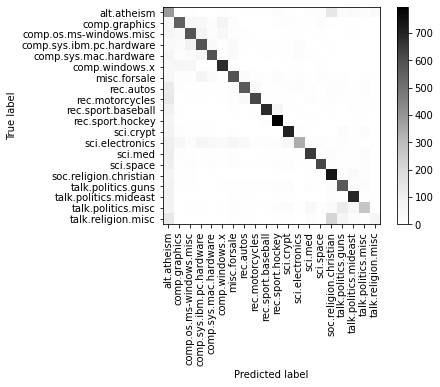

In [36]:
sklearn.metrics.plot_confusion_matrix(
    tuned_smpl_ppln, X_train, y_train,
    cmap=matplotlib.pyplot.cm.Greys,
    display_labels=ng20.target_names,
    include_values=False,
    xticks_rotation="vertical"
)

### Exkurs: Erklärung der &raquo;falschen Atheisten&laquo;

In [37]:
# Berechne Wahrscheinlichkeiten und vorhergesagte Klassen:
y_train_prob = tuned_smpl_ppln.predict_proba(X_train)
y_train_pred = tuned_smpl_ppln.predict(X_train)

In [38]:
# Finde alle Samples, die fälschlicherw. der Kategorie 0 (Atheismus) zugeordnet wurden:
false_atheists = numpy.logical_and(y_train>0, y_train_pred==0)
false_atheist_idcs = numpy.where(false_atheists)[0]
false_atheist_idcs.shape

(1565,)

In [39]:
# Betrachte Wahrscheinlichkeiten für diese Samples:
false_atheist_probas = y_train_prob[false_atheist_idcs,:]
false_atheist_probas.round(3)

array([[0.05 , 0.05 , 0.05 , ..., 0.05 , 0.05 , 0.05 ],
       [0.05 , 0.05 , 0.05 , ..., 0.05 , 0.05 , 0.05 ],
       [0.05 , 0.05 , 0.05 , ..., 0.05 , 0.05 , 0.05 ],
       ...,
       [0.05 , 0.05 , 0.05 , ..., 0.05 , 0.05 , 0.05 ],
       [0.115, 0.044, 0.044, ..., 0.063, 0.046, 0.055],
       [0.05 , 0.05 , 0.05 , ..., 0.05 , 0.05 , 0.05 ]])

In [40]:
# Welche dieser Samples haben konstante Wahrschinlichkeit für alle Klassen?
min_prob_per_sample = false_atheist_probas.min(axis=1)
max_prob_per_sample = false_atheist_probas.max(axis=1)
sample_has_constant_prob = (min_prob_per_sample == max_prob_per_sample)
numpy.unique(sample_has_constant_prob, return_counts=True)

(array([False,  True]), array([ 110, 1455]))

In [41]:
false_atheists_with_const_prob = false_atheist_idcs[sample_has_constant_prob]

In [42]:
print(X_train[false_atheists_with_const_prob[25]])

Hey Nick!  I got a bounce from postmaster@bnr.ca, it seems that they've never 
heard of a user 'npet'.  You should sort these guys out.


Tony


In [43]:
print(X_train[false_atheists_with_const_prob[527]])





That's what MCI Mail is for!  (CompuServe also has "CongressGrams" (TM).)

This is not intended as an advertisement; that really is what MCI Mail WAS
intended for (according to their ads).


In [44]:
print(X_train[false_atheists_with_const_prob[773]])


                                                          ~~15



## Zusammenfassung und Ausblick

### Zusammenfassung

- Feature-Selection ermöglicht Anpassung eines Modells auf einer (kleinen) Teilmenge der vorhandenen Features.
- Dies spart Rechen- und Speicherressourcen.
- Außerdem wird die Interpretierbarkeit verbessert.
- Bei der Wahl der Feature-Selection-Methode(n) sind technisches Verständnis und Experimentierfreudigkeit gefragt.

### Weiterführende Literatur

- [Feature selection (scikit-learn user guide)](https://scikit-learn.org/0.23/modules/feature_selection.html)
- A. Zheng, A. Casari: _Feature engineering for machine learning: principles and techniques for data scientists._ O'Reilly, 2018.
- I. Guyon, A. Elisseeff: "An introduction to variable and feature selection." _Journal of machine learning research_ 3: 1157-1182.
- Y. Saeys, I. Inza, P. Larrañaga: "A review of feature selection techniques in bioinformatics." _Bioinformatics_ 23: 2507-2517.